# Introduction


### About this notebook
Notebook này sẽ áp dụng chuỗi thời gian ARIMA và VARNN để dự báo các chỉ số kinh tế vĩ mô ở Việt Nam giai đoạn 2017 - 2023
#### 1. Data collection
#### 2. Data preprocessing
#### 3. Visualization
#### 4. Apply ARIMA and VARNN model to predict GDP, Inflation,.. 


## 1.1. Data collection

Dữ liệu thu thập từ trang web VBMA - Hiệp hội thị trường trái phiếu Việt Nam https://vbma.org.vn/vi/market-data/macro-economic-heatmap.        
## Dữ liệu chứa thông tin tổng quan kinh tế vĩ mô Việt Nam từ 2017 đến 2023.
## Dưới đây là mô tả chi tiết về các cột trong tập dữ liệu:

### FDI (Foreign Direct Investment)
**FDI đăng ký (lũy kế năm) % YoY**: Đo lường giá trị đầu tư trực tiếp nước ngoài đăng ký so với cùng kỳ năm trước.      
**FDI giải ngân (lũy kế năm) % YoY**: Đo lường giá trị vốn FDI đã giải ngân so với cùng kỳ năm trước.

### Thương mại (lũy kế năm)
**Xuất khẩu (lũy kế năm) % YoY**: Đo lường giá trị hàng hóa và dịch vụ xuất khẩu so với cùng kỳ năm trước.      
**Nhập khẩu (lũy kế năm) % YoY**: Đo lường giá trị hàng hóa và dịch vụ nhập khẩu so với cùng kỳ năm trước.

### Cung tiền & tín dụng
**Tăng trưởng tín dụng % YoY**: Đo lường sự gia tăng tổng giá trị các khoản vay tín dụng so với cùng kỳ năm trước.

### Tài khóa
**Tổng thu % YoY**: Đo lường sự tăng trưởng của tổng thu ngân sách nhà nước so với cùng kỳ năm trước.

### Chỉ số giá
**Lạm phát cơ bản % YoY**: Đo lường sự thay đổi của mức giá tiêu dùng, loại trừ giá thực phẩm và năng lượng so với cùng kỳ năm trước.

### Tăng trưởng GDP thực tế % YoY
**Tăng trưởng GDP thực tế % YoY**: Đo lường sự tăng trưởng của tổng sản phẩm quốc nội (GDP) thực tế so với cùng kỳ năm trước.

In [866]:
# Standard Libraries
import warnings
warnings.filterwarnings("ignore")
import math
from cmath import sqrt

# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Time Series Analysis
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from joblib import Parallel, delayed
# Deep Learning
import tensorflow as tf

In [867]:
file_path = 'data/vietnam_macro_economic.csv'
data = pd.read_csv(file_path)
data.head()

,Thời gian,FDI,FDI đăng kí (lũy kế năm),FDI giải ngân (lũy kế năm),Thương mại (lũy kế năm),Xuất khẩu (lũy kế năm),Nhập khẩu (lũy kế năm),Cung tiền & tín dụng,Tăng trưởng tín dụng,Nông nghiệp,...,Chi thường xuyên,Chỉ số giá,Lạm phát cơ bản,Lạm phát,Thực phẩm,Nhà ở và VLXD,Y tế,Vận tải,Chỉ số PMI,Tăng trưởng GDP thực tế
0,-,-,% YoY,% YoY,-,% YoY,% YoY,-,% YoY,% YoY,...,% YoY,-,% YoY,% YoY,% YoY,% YoY,% YoY,% YoY,-,% YoY
1,T1 2017,-,19,6.3,-,6,3.2,-,19.5,17.7,...,NaN,-,1.9,5.2,2.4,3.5,79.4,5,51.9,5.2
2,T2 2017,-,21.5,3.3,-,16.5,23.5,-,19.6,17.5,...,NaN,-,1.5,5,-0.3,4.8,79.8,10,54.2,5.2
3,T3 2017,-,91.5,3.4,-,15.7,25.4,-,21.6,17.9,...,NaN,-,1.6,4.7,-0.9,5.3,48.7,14.6,54.6,5.2
4,T4 2017,-,53.9,3.2,-,17.4,24.8,-,20.6,17.8,...,NaN,-,1.5,4.3,-1.7,4.3,63.6,11.1,54.1,6.4


In [868]:
data.columns

Index(['Thời gian', 'FDI', 'FDI đăng kí (lũy kế năm)',
       'FDI giải ngân (lũy kế năm)', 'Thương mại (lũy kế năm)',
       'Xuất khẩu  (lũy kế năm)', 'Nhập khẩu  (lũy kế năm)',
       'Cung tiền & tín dụng', 'Tăng trưởng tín dụng', 'Nông nghiệp',
       'Thương mại', 'Công nghiệp', 'Xây dựng', 'Cung tiền M2', 'Tài khóa',
       'Tổng thu', 'Nội địa', 'Tổng chi', 'Chi đầu tư phát triển',
       'Chi thường xuyên', 'Chỉ số giá', 'Lạm phát cơ bản', 'Lạm phát',
       'Thực phẩm', 'Nhà ở và VLXD', 'Y tế', 'Vận tải', 'Chỉ số PMI',
       'Tăng trưởng GDP thực tế'],
      dtype='object')

In [869]:
data.shape

(85, 29)

## 1.2. Data Preprocessing

### 1.2.1. Clean columns

In [870]:
data.columns

Index(['Thời gian', 'FDI', 'FDI đăng kí (lũy kế năm)',
       'FDI giải ngân (lũy kế năm)', 'Thương mại (lũy kế năm)',
       'Xuất khẩu  (lũy kế năm)', 'Nhập khẩu  (lũy kế năm)',
       'Cung tiền & tín dụng', 'Tăng trưởng tín dụng', 'Nông nghiệp',
       'Thương mại', 'Công nghiệp', 'Xây dựng', 'Cung tiền M2', 'Tài khóa',
       'Tổng thu', 'Nội địa', 'Tổng chi', 'Chi đầu tư phát triển',
       'Chi thường xuyên', 'Chỉ số giá', 'Lạm phát cơ bản', 'Lạm phát',
       'Thực phẩm', 'Nhà ở và VLXD', 'Y tế', 'Vận tải', 'Chỉ số PMI',
       'Tăng trưởng GDP thực tế'],
      dtype='object')

In [871]:
columns = ['Thoi_gian', 'FDI', 'FDI_dang_ki',
       'FDI_giai_ngan', 'Thuong_mai_luy_ke_nam',
       'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te']

data.columns = columns

print("Column names after cleaning:", data.columns)

Column names after cleaning: Index(['Thoi_gian', 'FDI', 'FDI_dang_ki', 'FDI_giai_ngan',
       'Thuong_mai_luy_ke_nam', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te'],
      dtype='object')


In [872]:
selected_columns = ['Thoi_gian', 'FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']
data = data[selected_columns]

# Drop hàng thứ 2 (hàng chứa thông tin về đơn vị)
data = data.drop(0)

data.head()
data.shape

(84, 8)

### 1.2.2. Convert date format

In [873]:
def convert_date(date_str):
    month_map = {
        'T1': '01', 'T2': '02', 'T3': '03', 'T4': '04', 'T5': '05',
        'T6': '06', 'T7': '07', 'T8': '08', 'T9': '09', 'T10': '10',
        'T11': '11', 'T12': '12'
    }
    month, year = date_str.split()
    month = month_map[month]
    return pd.to_datetime(f'{year}-{month}-01')


time_column = 'Thoi_gian'
data[time_column] = data[time_column].apply(convert_date)

data[time_column] = pd.to_datetime(data[time_column])
data.set_index(time_column, inplace=True)

data.head()

,FDI_dang_ki,Xuat_khau_luy_ke_nam,Nhap_khau_luy_ke_nam,Tang_truong_tin_dung,Cung_tien_M2,Lam_phat,Tang_truong_GDP_thuc_te
Thoi_gian,,,,,,,
2017-01-01,19,6,3.2,19.5,19.7,5.2,5.2
2017-02-01,21.5,16.5,23.5,19.6,18.1,5,5.2
2017-03-01,91.5,15.7,25.4,21.6,17.7,4.7,5.2
2017-04-01,53.9,17.4,24.8,20.6,17,4.3,6.4
2017-05-01,19.4,19,25.3,22,16.2,3.2,6.4


### 1.2.3. Handle missing value using interpolate

In [874]:
data.isna().sum()

FDI_dang_ki                0
Xuat_khau_luy_ke_nam       5
Nhap_khau_luy_ke_nam       2
Tang_truong_tin_dung       0
Cung_tien_M2               0
Lam_phat                   0
Tang_truong_GDP_thuc_te    0
dtype: int64

In [875]:
xuat_khau = 'Xuat_khau_luy_ke_nam'
nhap_khau = 'Nhap_khau_luy_ke_nam'

data[xuat_khau] = data[xuat_khau].replace({None: np.nan, '': np.nan})
data[nhap_khau] = data[nhap_khau].replace({None: np.nan, '': np.nan})

data[xuat_khau] = pd.to_numeric(data[xuat_khau], errors='coerce')
data[nhap_khau] = pd.to_numeric(data[nhap_khau], errors='coerce')

# Xử lí những giá trị null trong cột xuất khẩu và nhập khẩu bằng nội suy tuyến tính
data[xuat_khau] = data[xuat_khau].interpolate(method='linear')
data[nhap_khau] = data[nhap_khau].interpolate(method='linear')

data = data.astype(float)

In [876]:
data.head()

,FDI_dang_ki,Xuat_khau_luy_ke_nam,Nhap_khau_luy_ke_nam,Tang_truong_tin_dung,Cung_tien_M2,Lam_phat,Tang_truong_GDP_thuc_te
Thoi_gian,,,,,,,
2017-01-01,19.0,6.0,3.2,19.5,19.7,5.2,5.2
2017-02-01,21.5,16.5,23.5,19.6,18.1,5.0,5.2
2017-03-01,91.5,15.7,25.4,21.6,17.7,4.7,5.2
2017-04-01,53.9,17.4,24.8,20.6,17.0,4.3,6.4
2017-05-01,19.4,19.0,25.3,22.0,16.2,3.2,6.4


### 1.2.4. Detect outlier using IQR and Isolation Forest

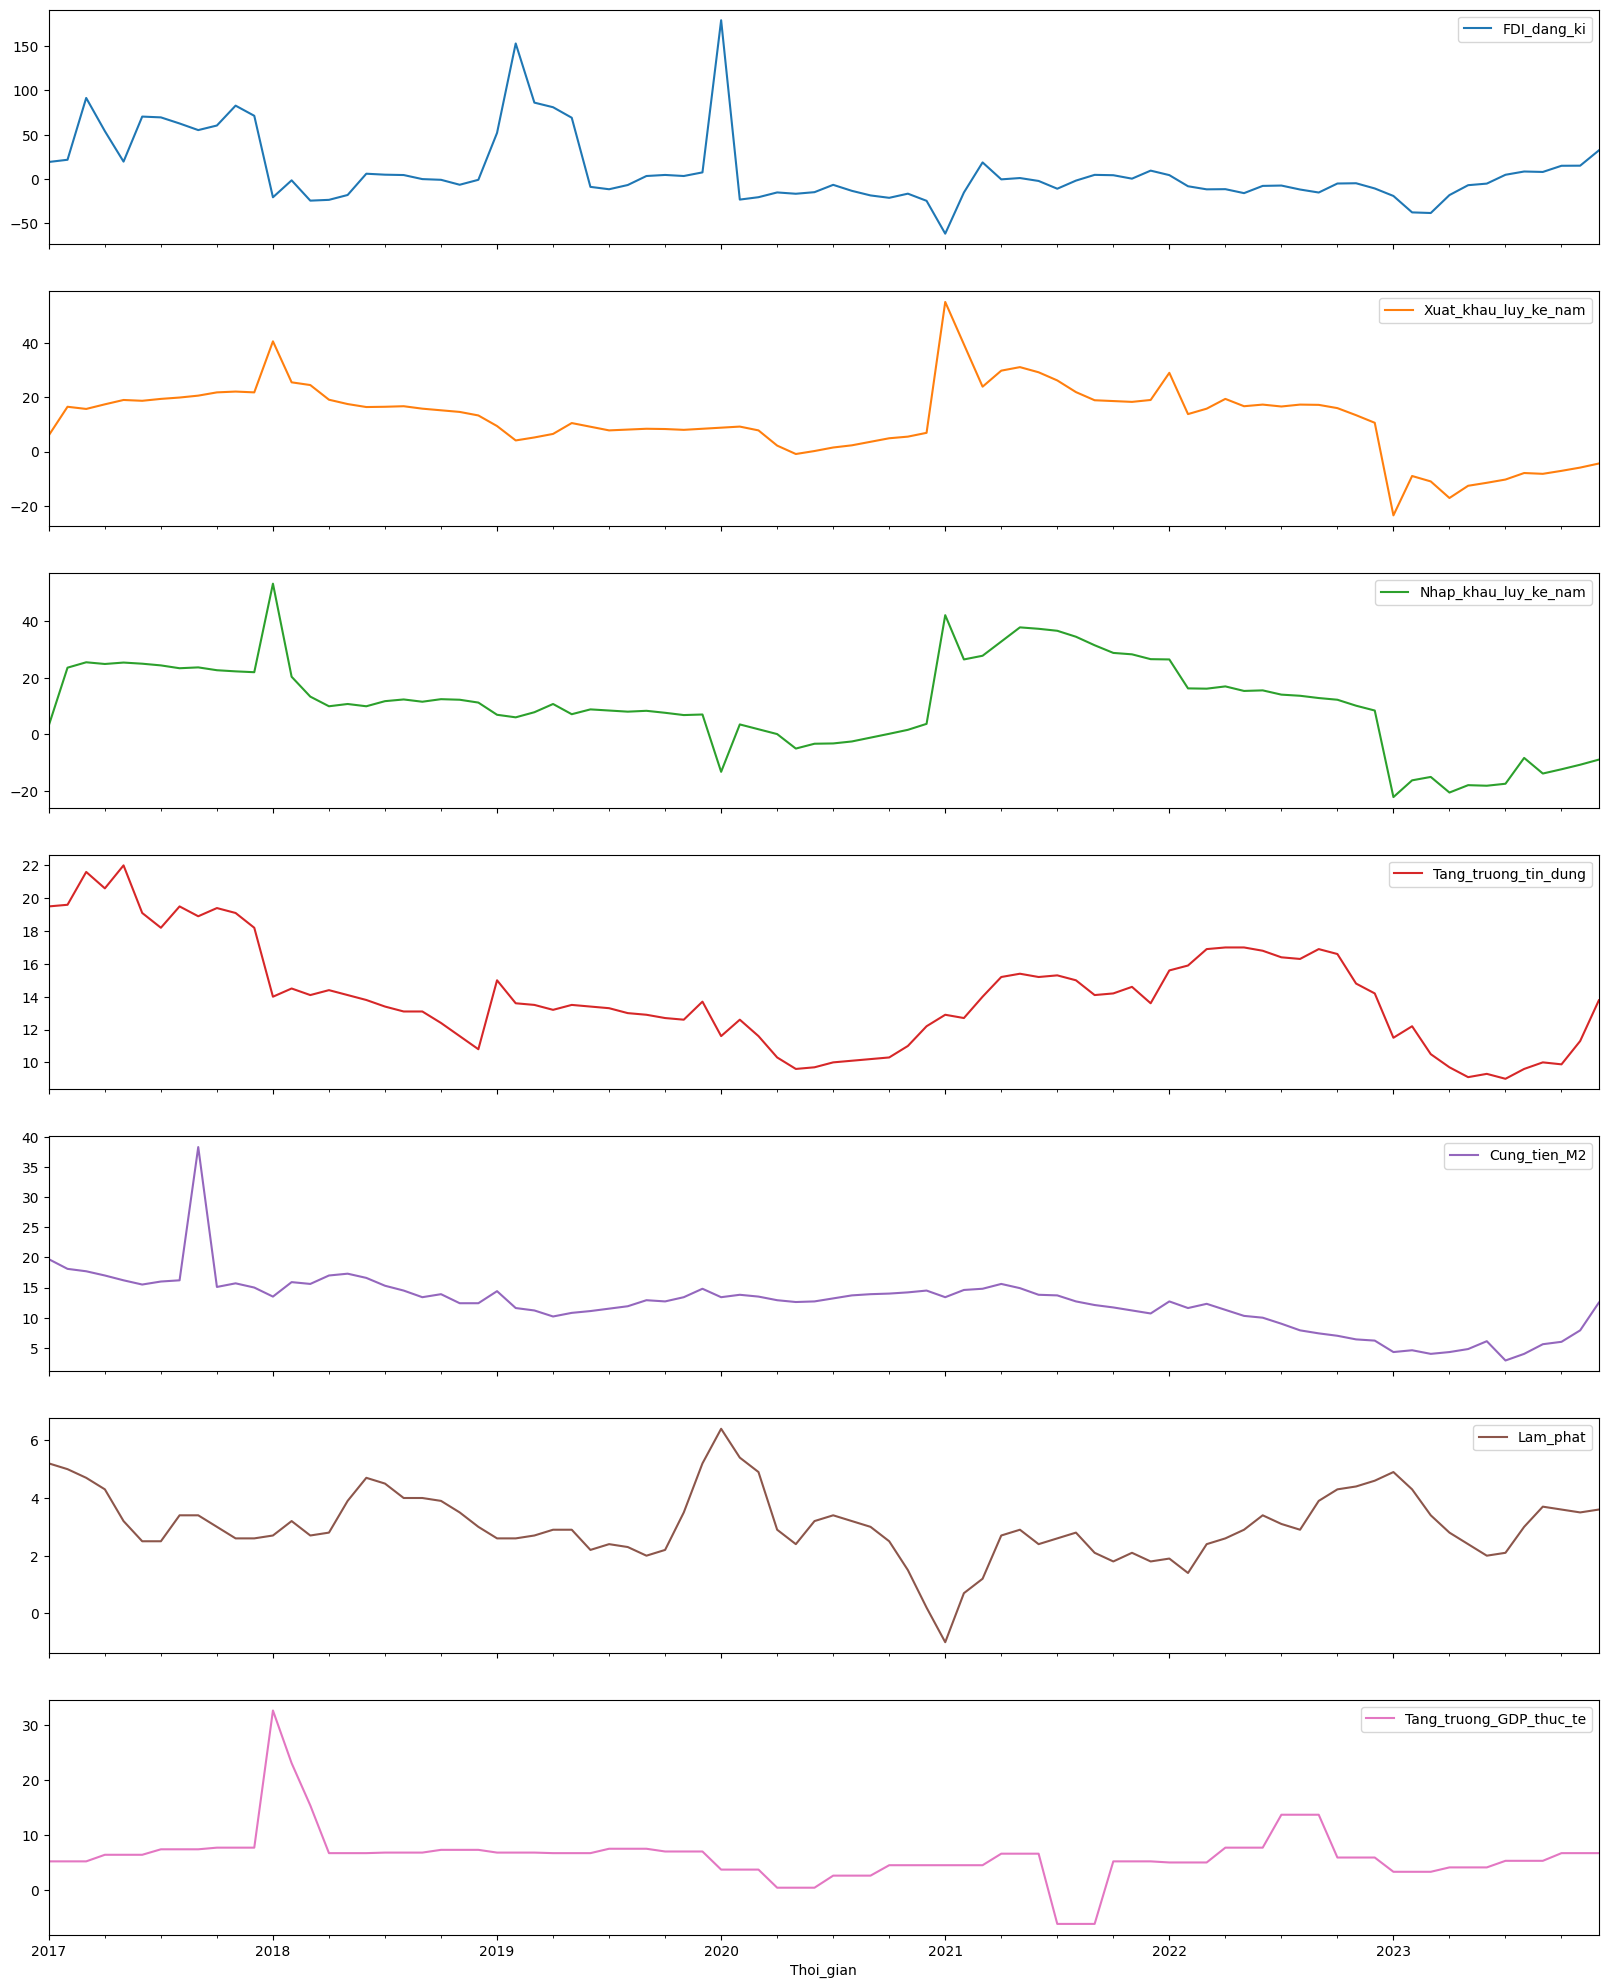

In [877]:
data.plot(subplots=True, figsize=(20, 25))
plt.show()

#### Có thể nhận thấy: dữ liệu có rất nhiều những giá trị bị xem là ngoại lai (những giai đoạn kinh tế phát triển cực nhanh chóng và những giai đoạn kinh tế khủng hoảng do đại dịch Covid 19)
### Ta tiến hành detect và handle outlier lần thứ nhất sử dụng IQR

In [878]:
def detect_outliers_iqr(data):
    outliers = {}
    for column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = data[(data[column] < lower_bound) | (data[column] > upper_bound)].index
    return outliers

outliers = detect_outliers_iqr(data)
outliers

{'FDI_dang_ki': DatetimeIndex(['2017-03-01', '2017-06-01', '2017-07-01', '2017-08-01',
                '2017-10-01', '2017-11-01', '2017-12-01', '2019-02-01',
                '2019-03-01', '2019-04-01', '2019-05-01', '2020-01-01',
                '2021-01-01'],
               dtype='datetime64[ns]', name='Thoi_gian', freq=None),
 'Xuat_khau_luy_ke_nam': DatetimeIndex(['2018-01-01', '2021-01-01', '2021-02-01', '2023-01-01',
                '2023-04-01'],
               dtype='datetime64[ns]', name='Thoi_gian', freq=None),
 'Nhap_khau_luy_ke_nam': DatetimeIndex([], dtype='datetime64[ns]', name='Thoi_gian', freq=None),
 'Tang_truong_tin_dung': DatetimeIndex(['2017-05-01'], dtype='datetime64[ns]', name='Thoi_gian', freq=None),
 'Cung_tien_M2': DatetimeIndex(['2017-09-01', '2023-01-01', '2023-02-01', '2023-03-01',
                '2023-04-01', '2023-07-01', '2023-08-01'],
               dtype='datetime64[ns]', name='Thoi_gian', freq=None),
 'Lam_phat': DatetimeIndex(['2020-01-01', '2020-12-

In [879]:
def handle_outliers_with_interpolation(data, outliers):
    for column, outlier_indices in outliers.items():
        for index in outlier_indices:
            if index in data.index:
                if index == data.index[0]:
                    next_index = data.index[1]
                    data.at[index, column] = data.at[next_index, column]
                elif index == data.index[-1]:
                    prev_index = data.index[-2]
                    data.at[index, column] = data.at[prev_index, column]
                else:
                    prev_index = data.index[data.index.get_loc(index) - 1]
                    next_index = data.index[data.index.get_loc(index) + 1]
                    data.at[index, column] = (data.at[prev_index, column] + data.at[next_index, column]) / 2

handle_outliers_with_interpolation(data, outliers)

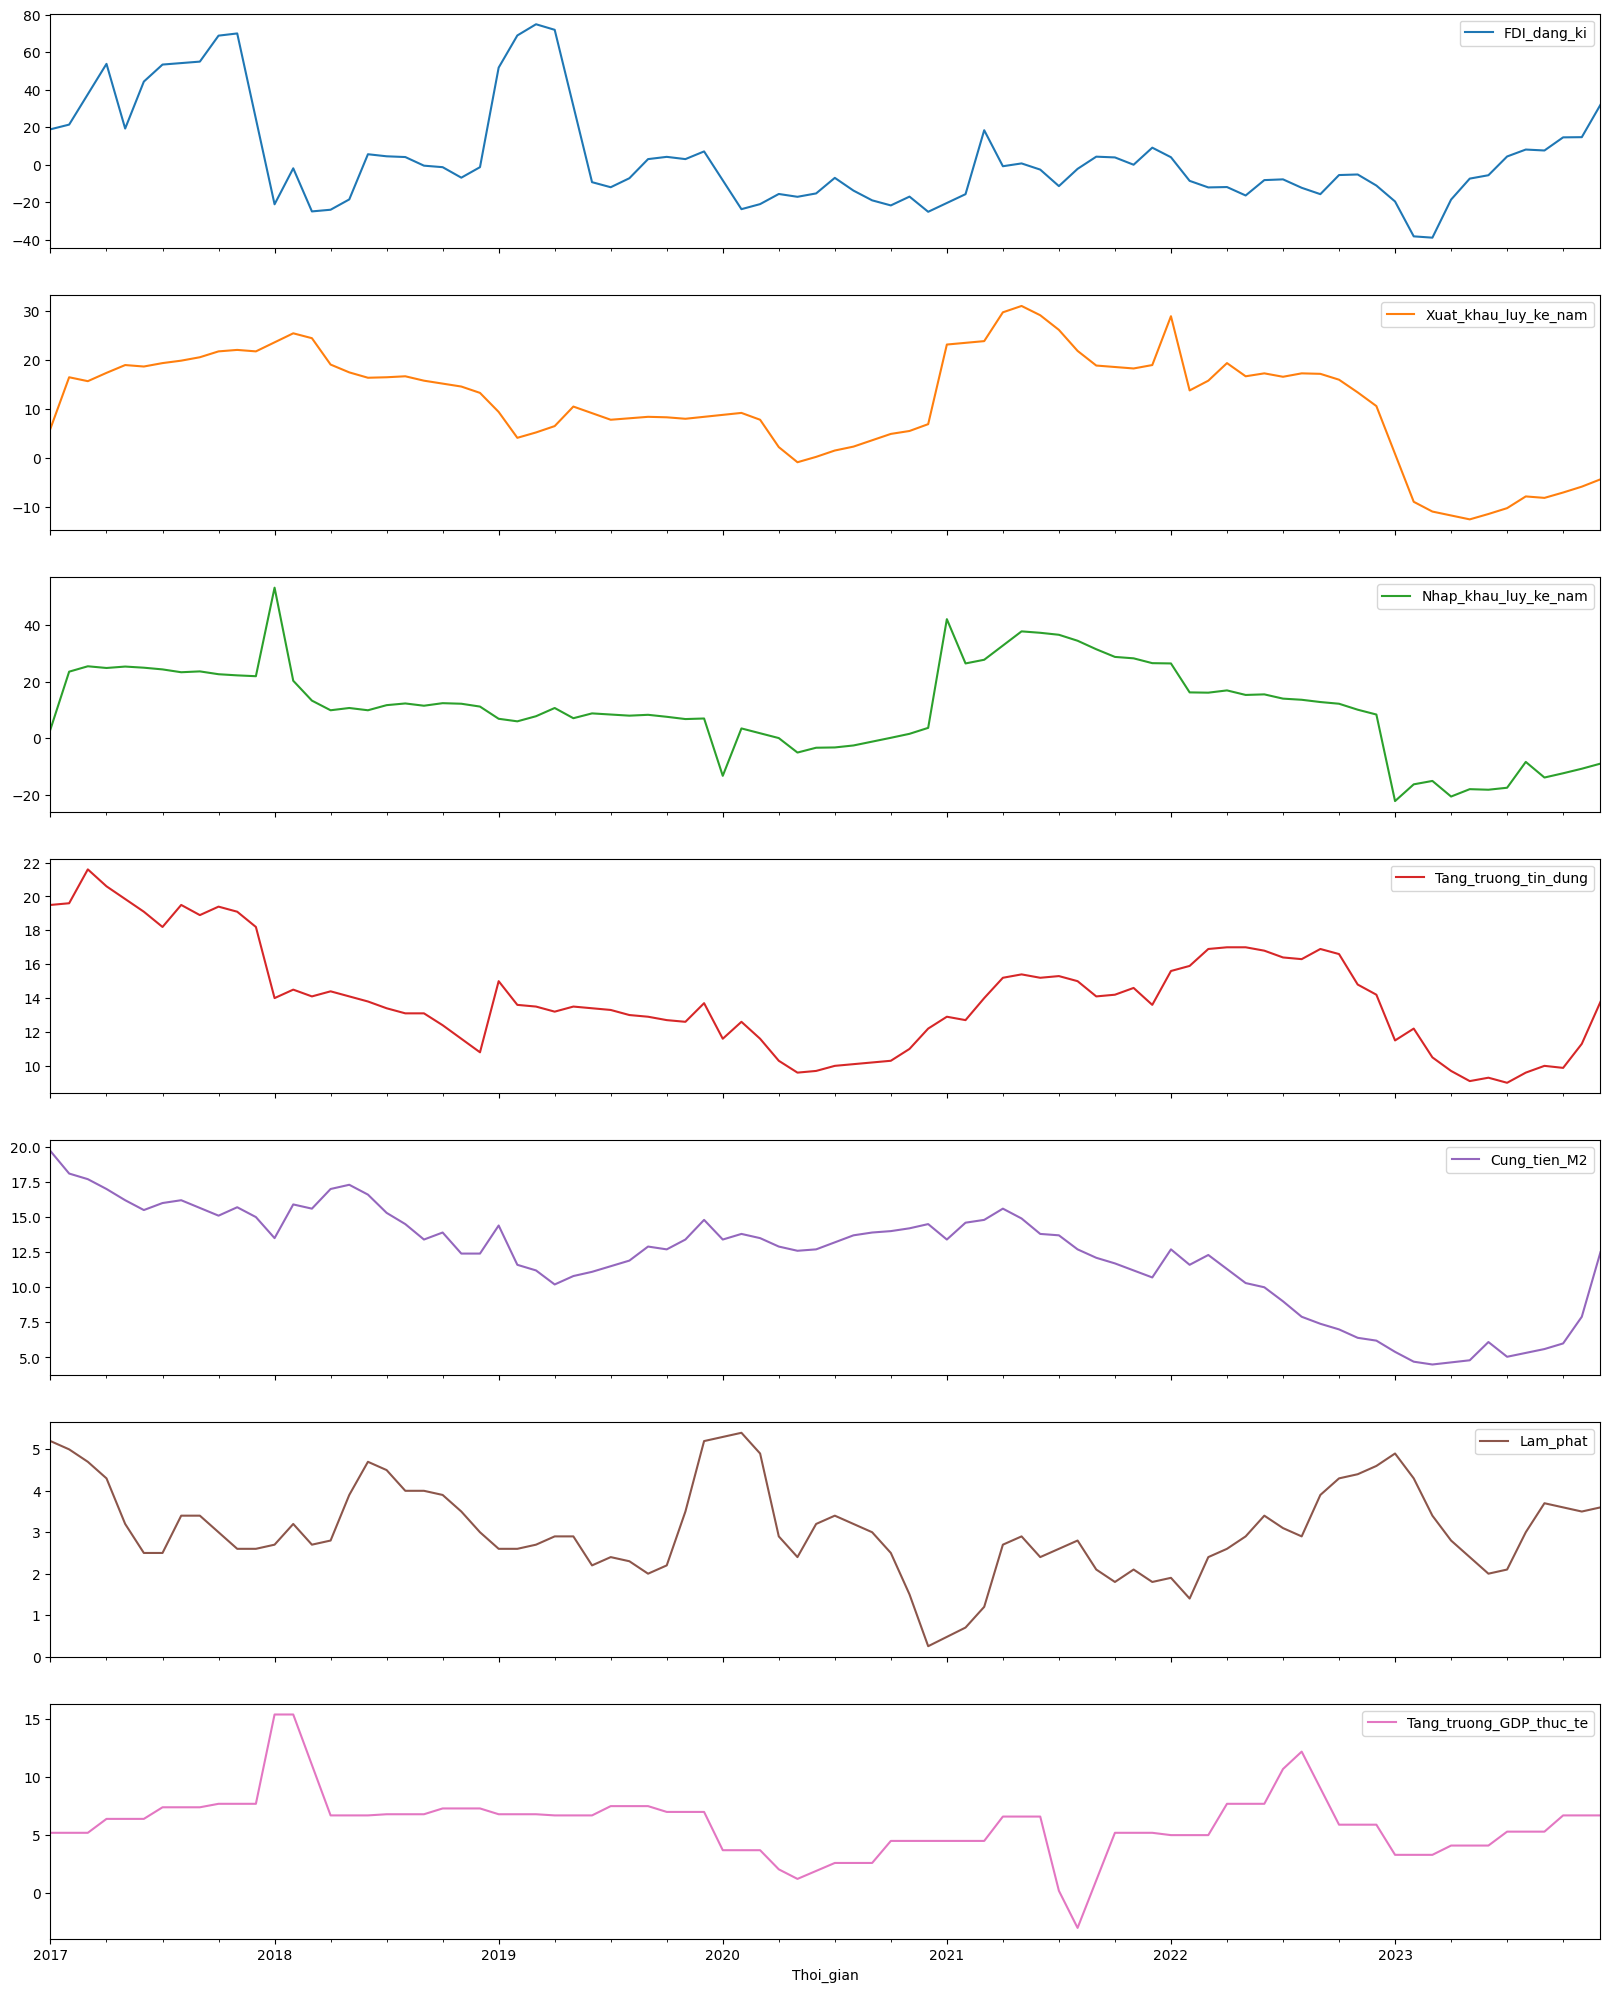

In [880]:
data.plot(subplots=True, figsize=(20, 25))
plt.show()

### Nhận thấy còn nhiều dữ liệu là outlier sau lần detect thứ nhất, ta tiếp tục detect và handle outlier sử dụng Isolation Forest

In [881]:
def detect_outliers_isolation_forest(data, contamination=0.15):
    outliers = {}
    for column in data.columns:
        model = IsolationForest(n_estimators=100, contamination=contamination)
        model.fit(data[[column]])
        y_anomaly = model.predict(data[[column]])
        outliers[column] = data.index[y_anomaly == -1]
    return outliers

In [882]:
outliers = detect_outliers_isolation_forest(data)
handle_outliers_with_interpolation(data, outliers)

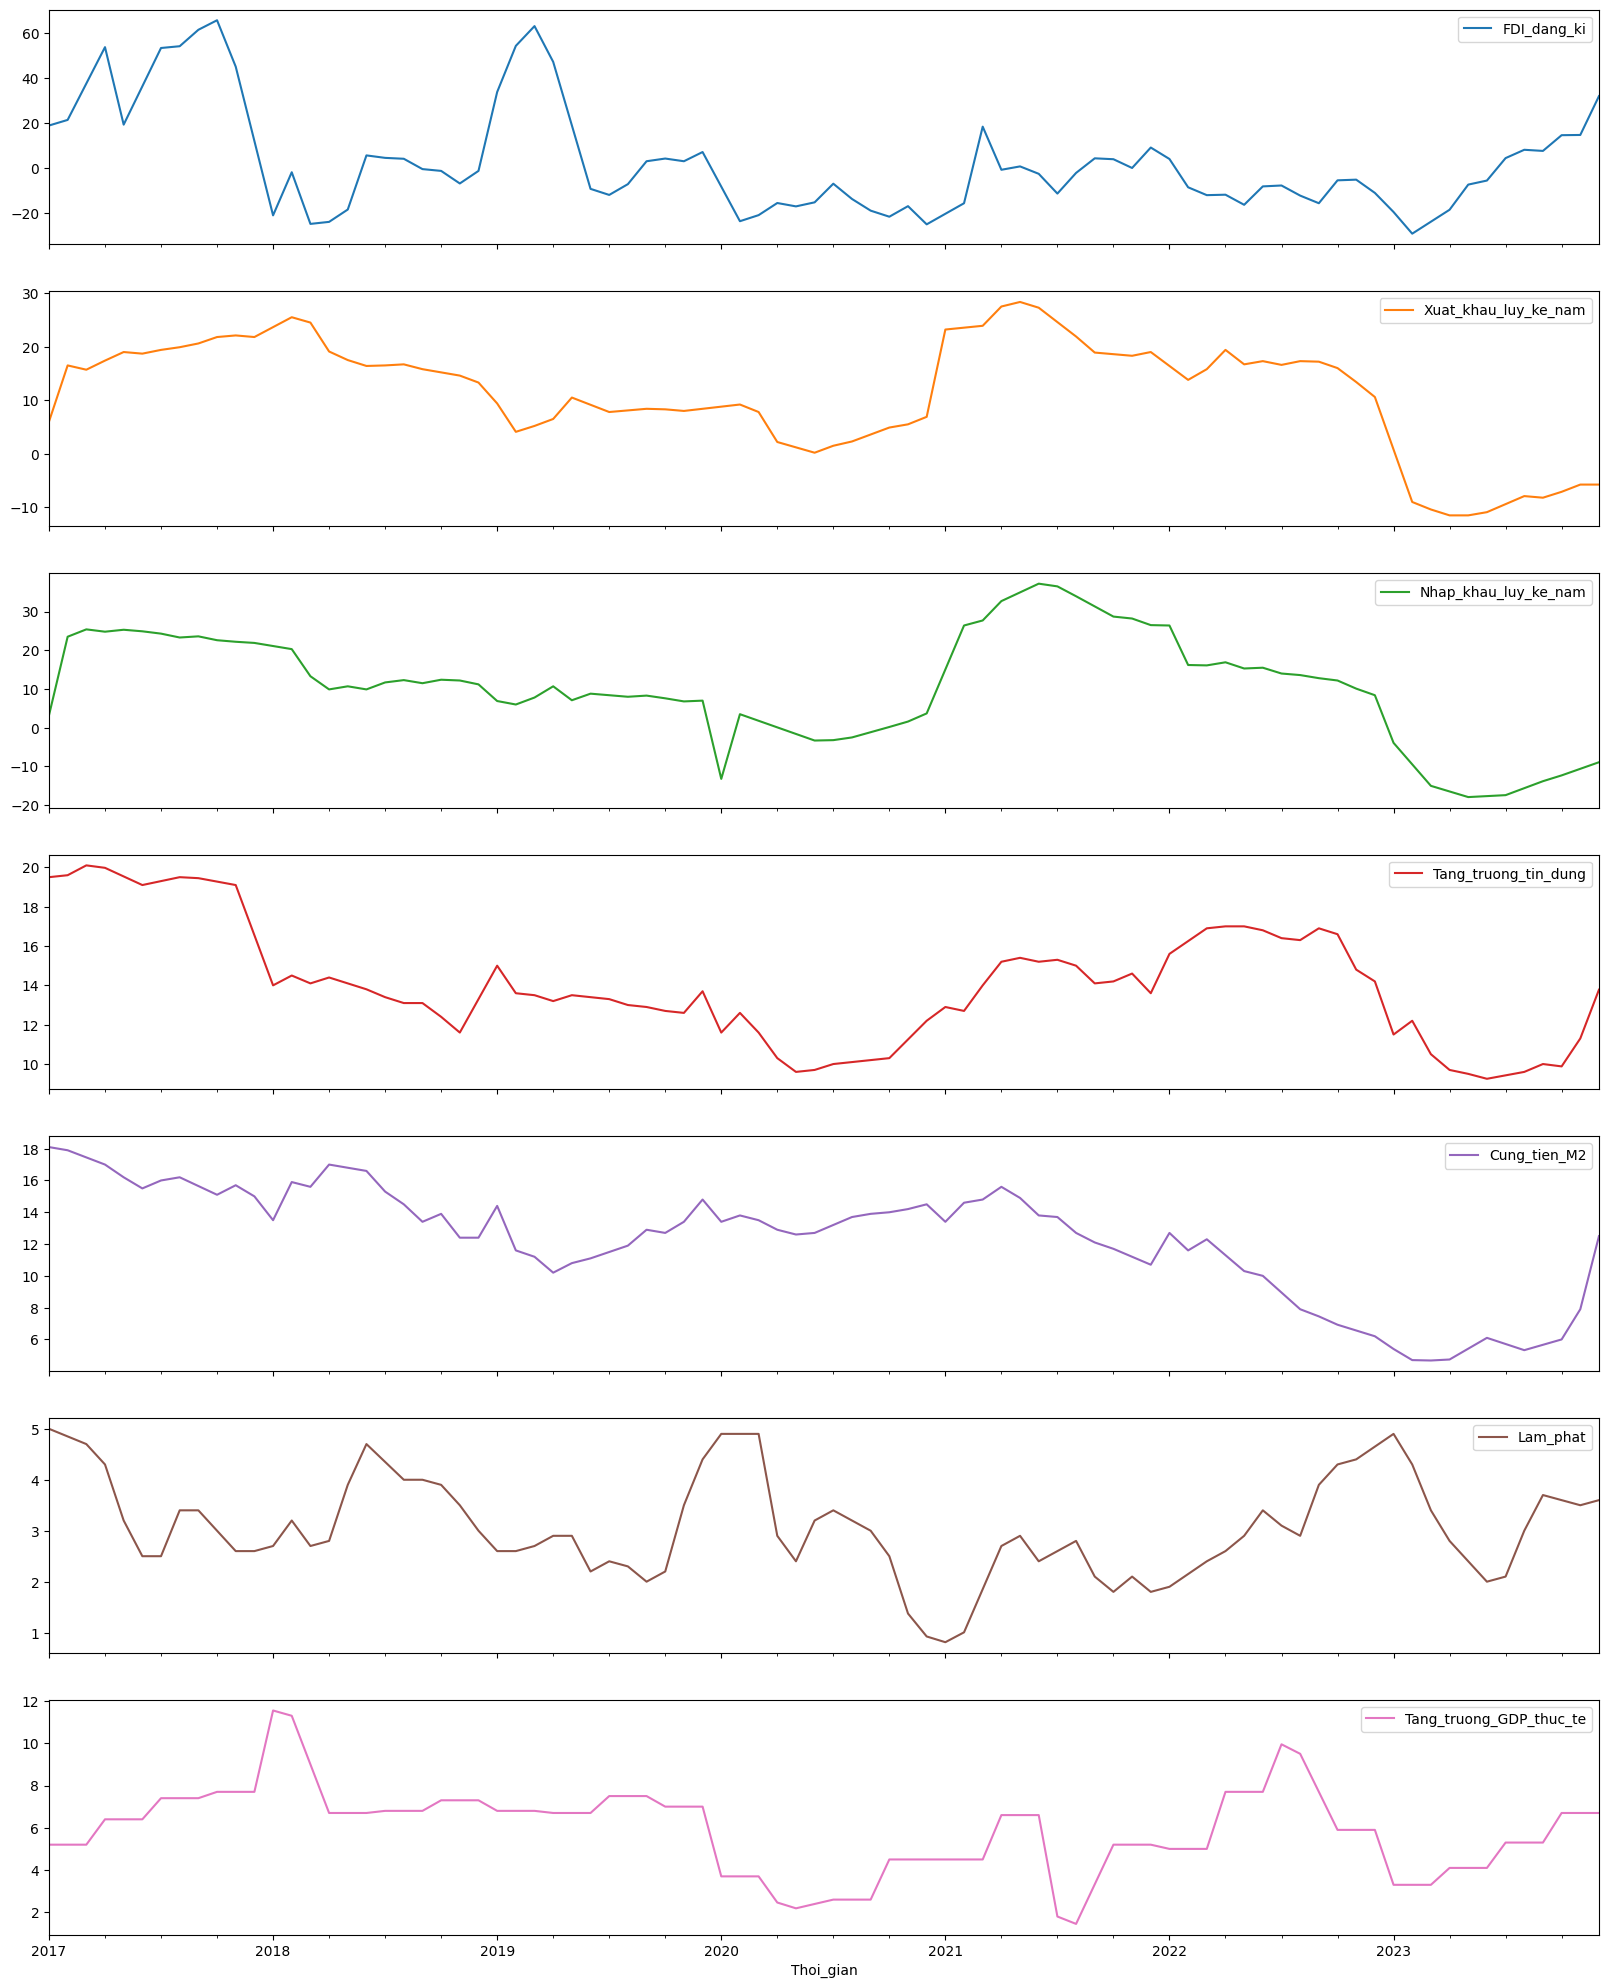

In [883]:
data.plot(subplots=True, figsize=(20, 25))
plt.show()

#### Hiện tại thì phần ngoại lệ đã được xử lí ổn hơn, ta có thể tiến hành những bước tiếp theo

### 1.2.5. Standardization

In [884]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
data[data.columns] = scaled_data

### 1.2.6. Check stationarity

#### Augmented Dickey-Fuller (ADF) test

In [885]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (reject H0), the series is stationary.\n")
    else:
        print("Weak evidence against the null hypothesis (fail to reject H0), the series is non-stationary.\n")

for column in data.columns:
    adf_test(data[column], title=column)

Augmented Dickey-Fuller Test: FDI_dang_ki
ADF Statistic                  -3.157605
p-value                         0.022574
# Lags Used                     1.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
Strong evidence against the null hypothesis (reject H0), the series is stationary.

Augmented Dickey-Fuller Test: Xuat_khau_luy_ke_nam
ADF Statistic                  -1.504401
p-value                         0.531333
# Lags Used                     1.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
Weak evidence against the null hypothesis (fail to reject H0), the series is non-stationary.

Augmented Dickey-Fuller Test: Nhap_khau_luy_ke_nam
ADF Statistic                  -2.032175
p-value                         0.272646
# Lags Used           

## 1.3. EDA

### 1.3.2. Corelation matrix

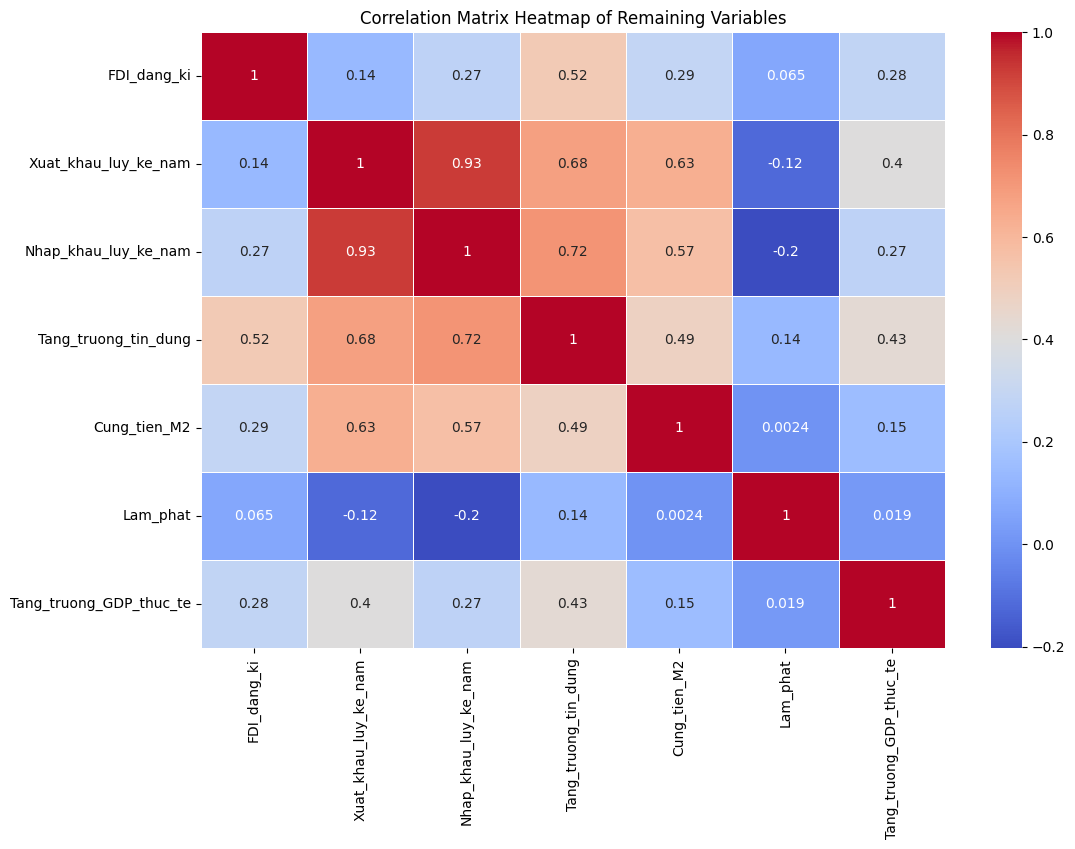

In [886]:
corr_matrix = data.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap of Remaining Variables')
plt.show()

### 1.3.2. Auto correlation

#### Lạm phát

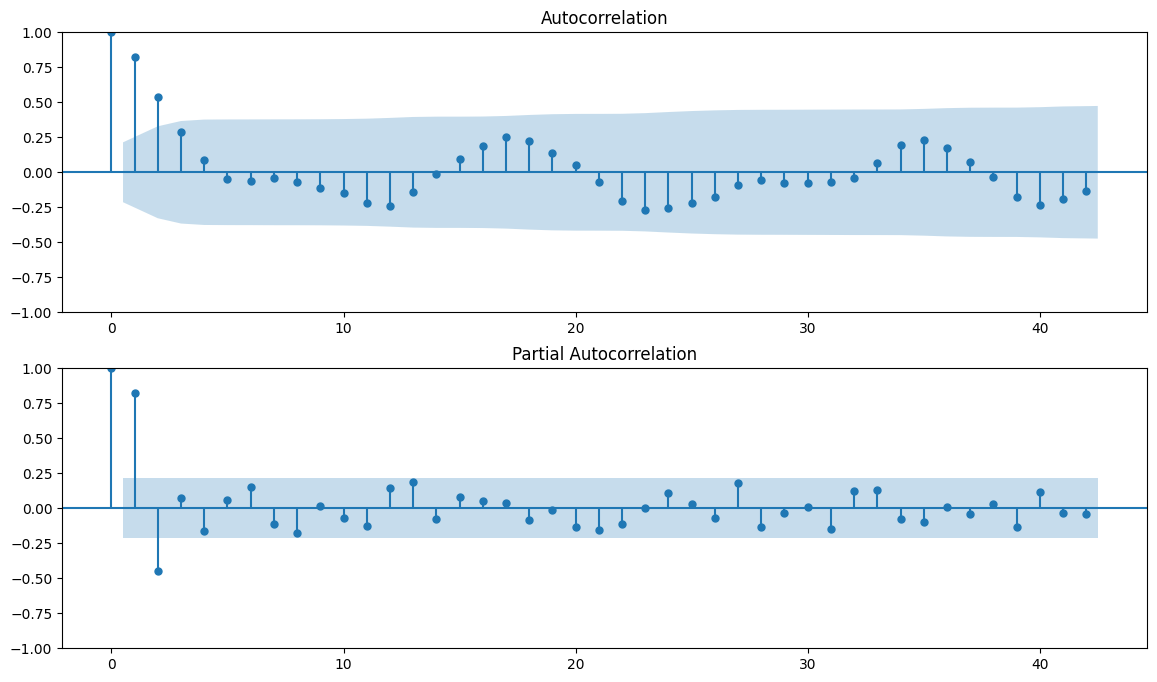

In [887]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))

plot_acf(data.Lam_phat,lags=42, ax=ax[0])
plot_pacf(data.Lam_phat,lags=42, ax=ax[1])
plt.show()

=> Có sự tự tương quan đáng kể ở các độ trễ đầu tiên, đặc biệt là độ trễ 1. Điều này cho thấy chuỗi thời gian có thể không hoàn toàn là ngẫu nhiên.

#### Tăng trưởng GDP thực tế

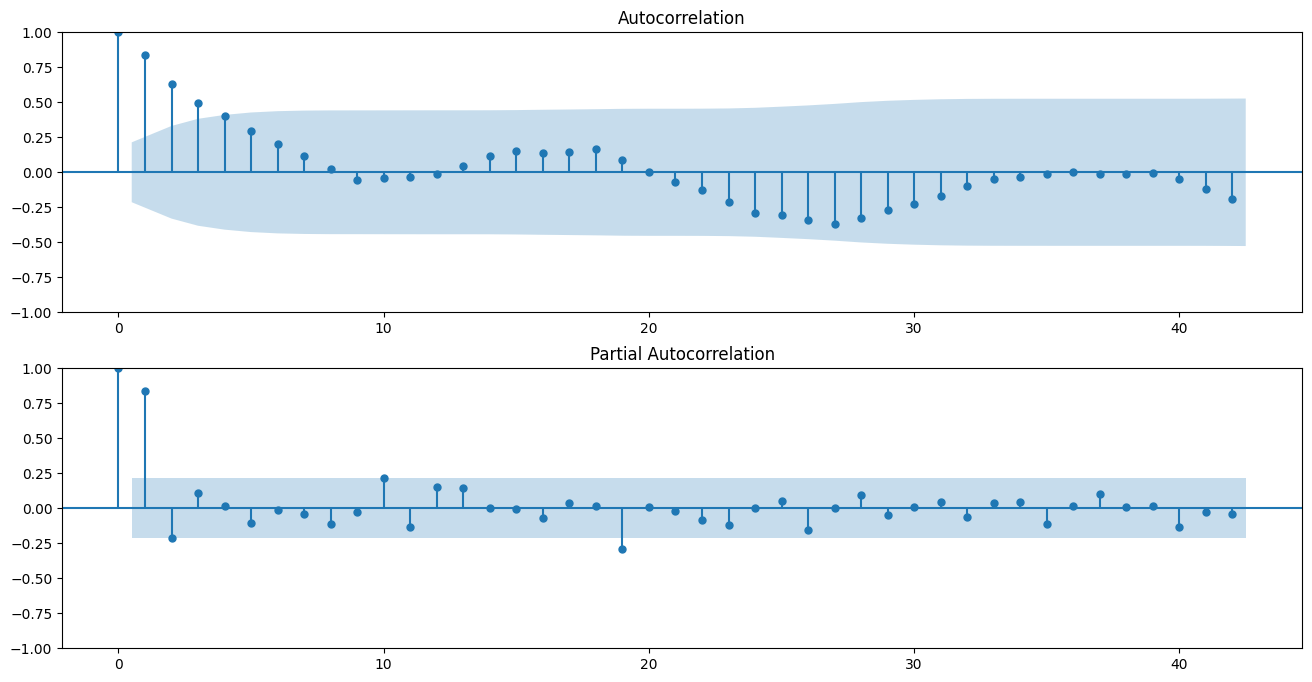

In [888]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[0])
plot_pacf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[1])
plt.show()

## 1.4. Model

In [889]:
train_data = data['2017-01-01':'2021-05-01']
test_data = data['2021-06-01':'2023-12-01']

### 1.4.1. ARIMA model

In [890]:
target_1 = 'Lam_phat'
y_train_1 = train_data[target_1]
y_test_1 = test_data[target_1]

target_2 = 'Tang_truong_GDP_thuc_te'
y_train_2 = train_data[target_2]
y_test_2 = test_data[target_2]

#### Lạm phát

In [891]:
model = ARIMA(y_train_1, order=(3, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Lam_phat   No. Observations:                   53
Model:                 ARIMA(3, 1, 1)   Log Likelihood                  35.963
Date:                Thu, 30 May 2024   AIC                            -61.925
Time:                        10:12:35   BIC                            -52.169
Sample:                    01-01-2017   HQIC                           -58.185
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3007      7.248      0.041      0.967     -13.904      14.506
ar.L2         -0.2247      3.854     -0.058      0.954      -7.779       7.330
ar.L3         -0.0545      2.499     -0.022      0.9

Hệ số có ý nghĩa thống kê: Các hệ số AR(2), AR(3), MA(2), và hằng số có ý nghĩa thống kê vì giá trị p của chúng nhỏ hơn 0.05.       
Các hệ số AR(1) và MA(1) không có ý nghĩa thống kê.         
Tính phù hợp của mô hình: AIC, BIC, và HQIC đều rất thấp, cho thấy mô hình này có khả năng phù hợp tốt với dữ liệu.

In [892]:
forecast_1 = model_fit.forecast(steps=len(y_test_1)) 
forecast_1 = forecast_1.rename('Forecast_1')

In [893]:
mse = mean_squared_error(y_test_1, forecast_1)
mae = mean_absolute_error(y_test_1, forecast_1)
rmse = sqrt(mean_squared_error(y_test_1, forecast_1))

print(f"Model Evaluation Metrics:")
print(f"{'Metric':<10} {'Value':<20}")
print(f"{'-'*30}")
print(f"{'MSE':<10} {mse:<20.4f}")
print(f"{'MAE':<10} {mae:<20.4f}")
print(f"{'RMSE':<10} {rmse:<20.4f}")

Model Evaluation Metrics:
Metric     Value               
------------------------------
MSE        0.0531              
MAE        0.1835              
RMSE       0.2304+0.0000j      


#### Tăng trưởng GDP thực tế

In [894]:
model = ARIMA(y_train_2, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:     Tang_truong_GDP_thuc_te   No. Observations:                   53
Model:                      ARIMA(1, 0, 1)   Log Likelihood                  50.773
Date:                     Thu, 30 May 2024   AIC                            -93.547
Time:                             10:12:35   BIC                            -85.666
Sample:                         01-01-2017   HQIC                           -90.516
                              - 05-01-2021                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4583      0.092      4.979      0.000       0.278       0.639
ar.L1          0.8118      0.087      9.382      0.000       0.642       0.981
ma.L1       

In [895]:
forecast_2 = model_fit.forecast(steps=len(y_test_2))
forecast_2 = forecast_2.rename('Forecast_2')
mape_gdp = np.mean(np.abs(forecast_2 - y_test_2)/np.abs(y_test_2))

In [896]:
mse = mean_squared_error(y_test_2, forecast_2)
mae = mean_absolute_error(y_test_2, forecast_2)
rmse = sqrt(mean_squared_error(y_test_2, forecast_2))

print(f"Model Evaluation Metrics:")
print(f"{'Metric':<10} {'Value':<20}")
print(f"{'-'*30}")
print(f"{'MSE':<10} {mse:<20.4f}")
print(f"{'MAE':<10} {mae:<20.4f}")
print(f"{'RMSE':<10} {rmse:<20.4f}")

Model Evaluation Metrics:
Metric     Value               
------------------------------
MSE        0.0425              
MAE        0.1648              
RMSE       0.2061+0.0000j      


#### Plot the result

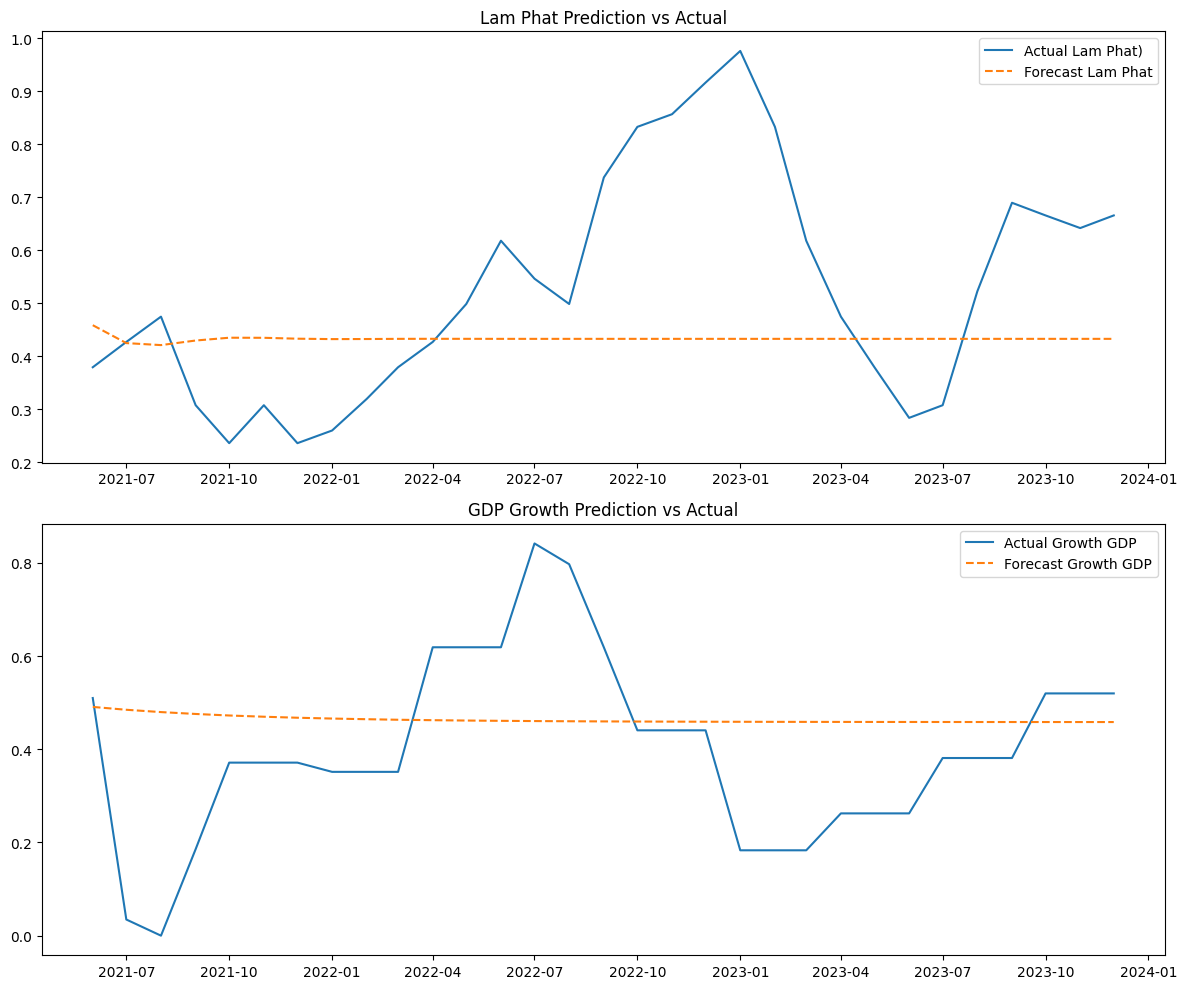

In [897]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

ax[0].plot(y_test_1, label=f'Actual Lam Phat)')
ax[0].plot(forecast_1, label='Forecast Lam Phat', linestyle='--')
ax[0].legend()
ax[0].set_title('Lam Phat Prediction vs Actual')

ax[1].plot(y_test_2, label=f'Actual Growth GDP')
ax[1].plot(forecast_2, label='Forecast Growth GDP', linestyle='--')
ax[1].legend()
ax[1].set_title('GDP Growth Prediction vs Actual')

plt.tight_layout()
plt.show()

### Kết luận về việc dự báo sử dụng mô hình ARIMA:

**Dự báo Tăng trưởng GDP thực tế:**
- **MSE (Mean Squared Error)**: 0.0425
- **MAE (Mean Absolute Error)**: 0.1648
- **RMSE (Root Mean Squared Error)**: 0.2061

**Dự báo Lạm Phát:**
- **MSE**: 0.0452
- **MAE**: 0.1750
- **RMSE**: 0.2127

#### Đánh giá:
- Các chỉ số MSE, MAE và RMSE của cả hai dự báo đều ở mức chấp nhận được, **nhưng không nói lên được gì nhiều**.
- Hơn nữa, có thể thấy rằng giá trị thực tế của các chỉ số có sự biến động rất lớn, không nắm bắt được xu hướng của dữ liệu, đôi khi vượt xa dự báo của mô hình, điều này thể hiện rõ ràng hơn qua các đồ thị.
- Nhìn chung, mô hình ARIMA không phù hợp trong trường hợp dữ liệu có ít dòng như trong bài toán này 
-> đưa đến áp dụng mô hình mới

## 1.4.2. VARNN model

In [898]:
features = ['FDI_dang_ki','Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']
target = ['FDI_dang_ki','Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']

trainY = train_data[target]
trainX = train_data[features]

testY = test_data[target]
testX = test_data[features]

### Tạo các biến trễ (lagged features) từ một tập dữ liệu gốc
Tạo các biến trễ từ 1 đến 6 kỳ trước đó

In [899]:
p = 6

def create_lagged_features(data, features, p):
    lagged_data = pd.DataFrame(index=data.index)
    for feature in features:
        for lag in range(1, p + 1):
            lagged_data[f'{feature}_lag{lag}'] = data[feature].shift(lag)
    lagged_data.dropna(inplace=True)
    return lagged_data

In [900]:
trainX_lagged = create_lagged_features(trainX, features, p)
testX_lagged = create_lagged_features(testX, features, p)

trainY = trainY.loc[trainX_lagged.index]
testY = testY.loc[testX_lagged.index]

In [901]:
trainX_lagged = trainX_lagged.to_numpy()
trainY = trainY.to_numpy()
testX_lagged = testX_lagged.to_numpy()
testY = testY.to_numpy()

In [902]:
num_outputs = len(target)
num_outputs

7

#### Build model

In [903]:
ffnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(trainX_lagged.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    ])

var_model = tf.keras.layers.Dense(num_outputs)

class CustomModel(tf.keras.Model):
    def __init__(self, ffnn_model, var_model):
        super(CustomModel, self).__init__()
        self.ffnn_model = ffnn_model
        self.var_model = var_model

    def call(self, inputs):
        ffnn_output = self.ffnn_model(inputs)
        var_output = self.var_model(ffnn_output)
        return var_output

Khởi tạo và compile mô hình

In [904]:
custom_model = CustomModel(ffnn_model, var_model)
custom_model.compile(optimizer='adam', loss='mse')

#### Huấn luyện và đánh giá mô hình trên tập dữ liệu kiểm tra

In [905]:
custom_model.fit(trainX_lagged, trainY, verbose=1, epochs=100, batch_size=64, validation_split=0.2)

loss = custom_model.evaluate(testX_lagged, testY)
print(f'Test Loss: {loss}')

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.6414 - val_loss: 0.3456
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.5614 - val_loss: 0.3126
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.4898 - val_loss: 0.2834
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.4275 - val_loss: 0.2572
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.3738 - val_loss: 0.2341
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.3287 - val_loss: 0.2139
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.2917 - val_loss: 0.1963
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2619 - val_loss: 0.1810
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.2376 - val_loss: 0.1682
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.2180 - val_loss: 0.1574
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.2013 - val_loss: 0.1483
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1859 -

### Dự đoán

In [906]:
predictions = custom_model.predict(testX_lagged)

predictions_df = pd.DataFrame(predictions, index=test_data.index[p:], columns=target)

print("Predictions on test data:")
predictions_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Predictions on test data:


,FDI_dang_ki,Xuat_khau_luy_ke_nam,Nhap_khau_luy_ke_nam,Tang_truong_tin_dung,Cung_tien_M2,Lam_phat,Tang_truong_GDP_thuc_te
Thoi_gian,,,,,,,
2021-12-01,0.391548,0.621124,0.607275,0.504432,0.752349,0.487393,0.472944
2022-01-01,0.384503,0.587000,0.549492,0.493696,0.713822,0.490131,0.481952
2022-02-01,0.427079,0.577310,0.517972,0.542822,0.695392,0.523231,0.448157
2022-03-01,0.381806,0.599735,0.488714,0.557456,0.707386,0.515647,0.470058
2022-04-01,0.366165,0.605596,0.498844,0.529371,0.733236,0.496791,0.426775


#### Plot the result

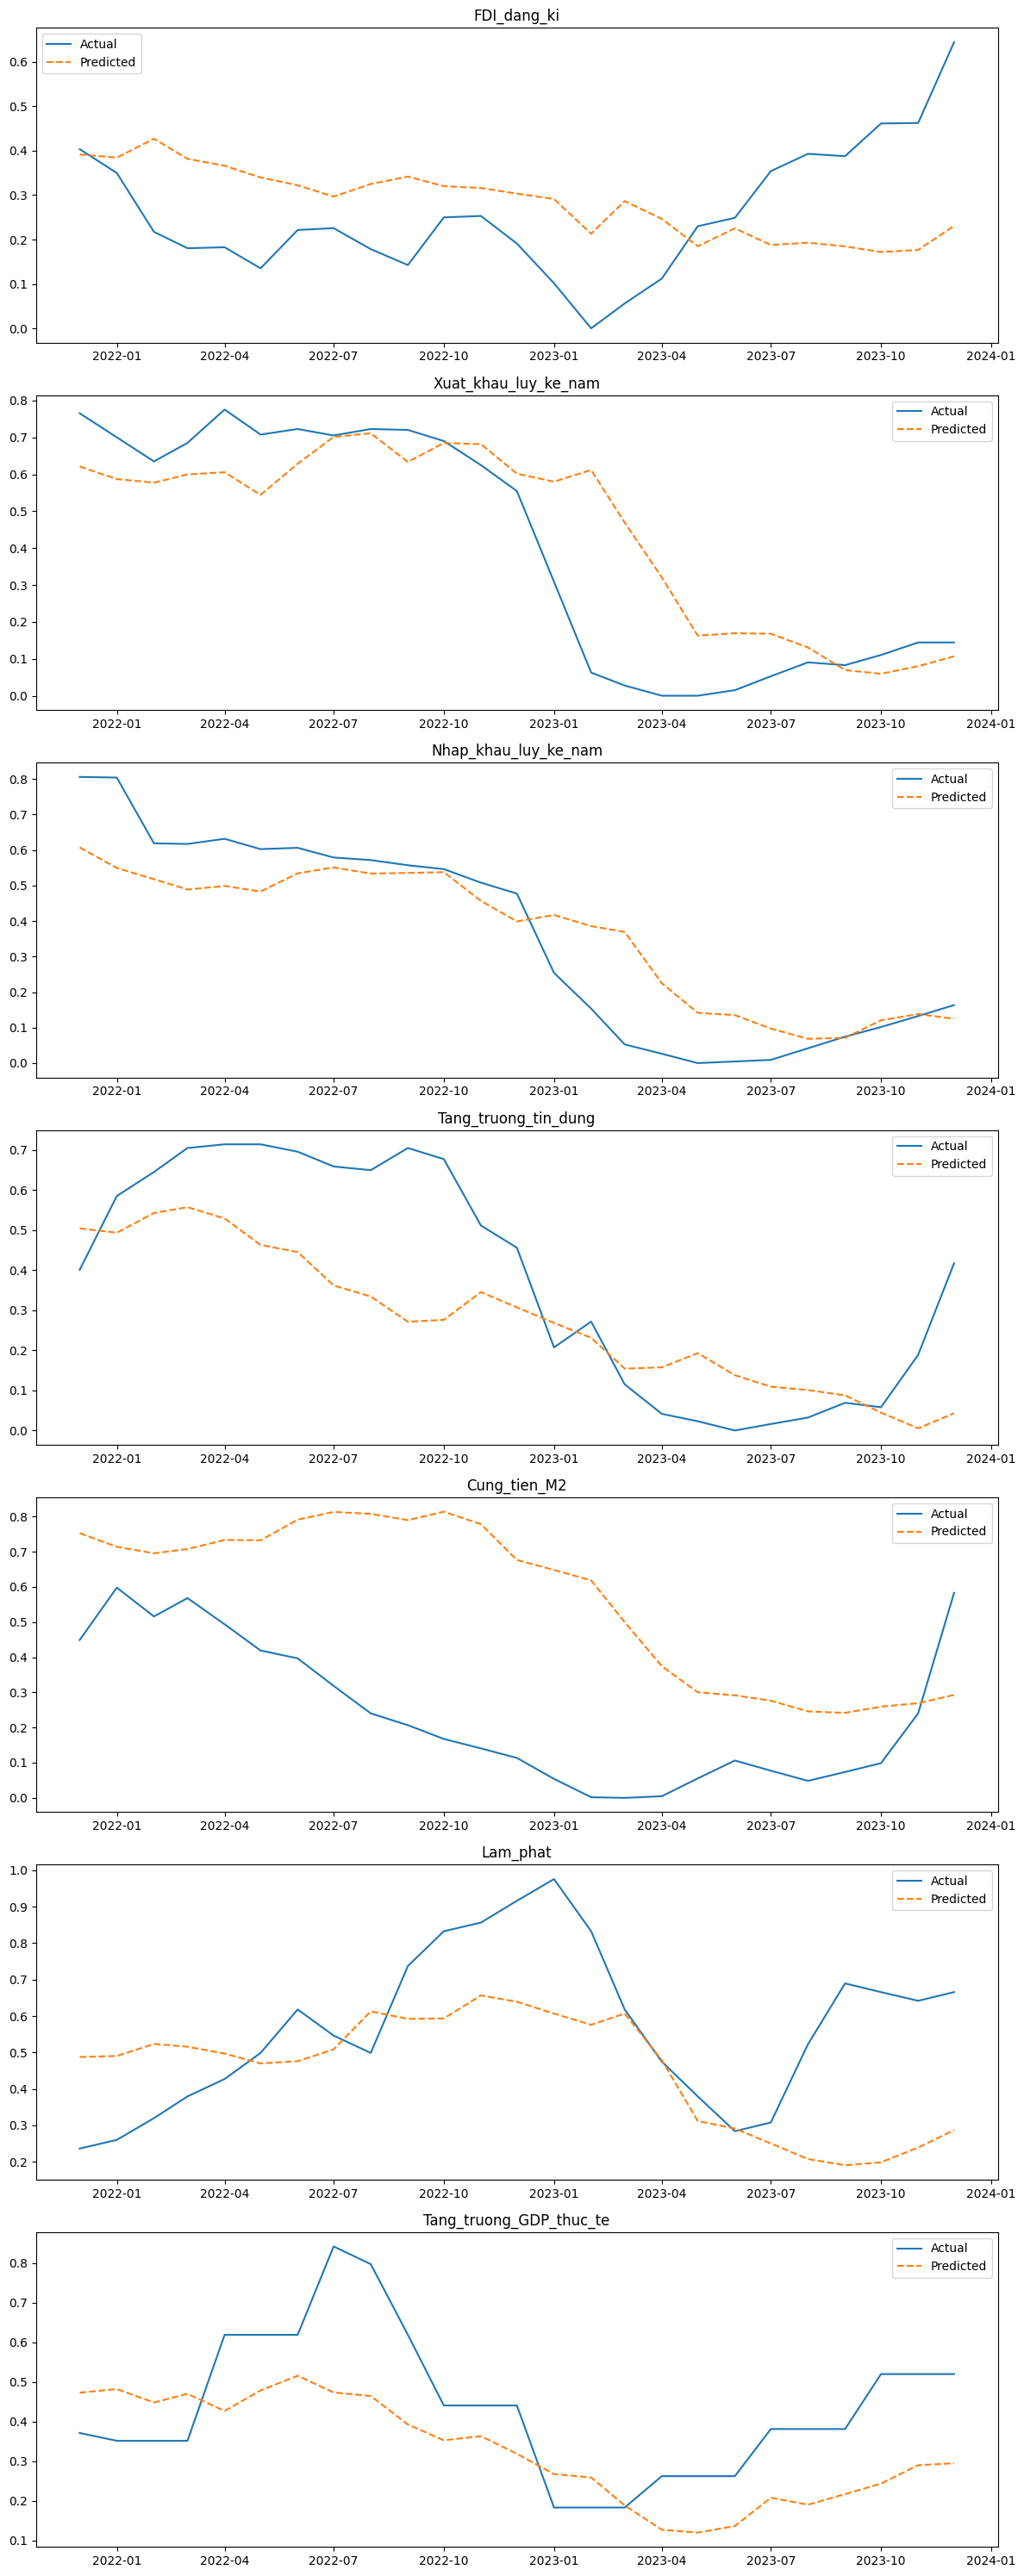

In [907]:
plt.figure(figsize=(12, 30))
for i, col in enumerate(target):
    plt.subplot(len(target), 1, i+1)
    plt.plot(test_data.index[p:], testY[:, i], label='Actual')
    plt.plot(test_data.index[p:], predictions[:, i], label='Predicted', linestyle='--')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

In [908]:
mse = mean_squared_error(testY, predictions)
mae = mean_absolute_error(testY, predictions)
rmse = sqrt(mean_squared_error(testY, predictions))

print(f"Model Evaluation Metrics:")
print(f"{'Metric':<10} {'Value':<20}")
print(f"{'-'*30}")
print(f"{'MSE':<10} {mse:<20.4f}")
print(f"{'MAE':<10} {mae:<20.4f}")
print(f"{'RMSE':<10} {rmse:<20.4f}")

Model Evaluation Metrics:
Metric     Value               
------------------------------
MSE        0.0540              
MAE        0.1808              
RMSE       0.2325+0.0000j      


### Kết luận về mô hình dự báo sử dụng VARNN
##### Có thể thấy, dù loss được đo lường là tổng của tất cả sai số trên 7 feature nhưng các loss MSE, MAE, RMSE lại rất nhỏ so với loss khi chỉ dự báo cho một biến là GDP hay Lạm Phát đối với mô hình ARIMA
##### Hơn nữa, Mô hình VARNN thực hiện khá tốt trong việc bắt kịp xu hướng chung của các chỉ số kinh tế vĩ mô. Một tín hiệu đáng mừng cho thấy sức mạnh của VARNN đối với tập dữ liệu tương đối hạn chế về số dòng này.
-------------------------------------------------------------------------------------------------------------------------------------------------------
## THANK YOU FOR WATCHING